<a href="https://colab.research.google.com/github/9mithun9/Rossmann-Sales-Prediction/blob/main/Rossman_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets xgboost lightgbm graphviz kaggle

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import opendatasets as od
import os
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
od.download('https://www.kaggle.com/competitions/rossmann-store-sales/data')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [ ]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'train.csv', 'test.csv', 'store.csv']

In [ ]:
ross_df = pd.read_csv('rossmann-store-sales/train.csv')
store_df = pd.read_csv('rossmann-store-sales/store.csv')
test_df = pd.read_csv('rossmann-store-sales/test.csv')

<ipython-input-131-6132c8560089>:1: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
merged_df = pd.merge(ross_df, store_df, on='Store', how='left')
merged_test_df = pd.merge(test_df, store_df, on='Store', how='left')

In [ ]:
merged_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
593230,836,4,2014-01-16,4540,598,1,0,0,0,a,a,2720.0,9.0,2012.0,0,NaN,NaN,NaN
536075,546,6,2014-03-08,12624,1407,1,0,0,0,a,a,580.0,1.0,2005.0,0,NaN,NaN,NaN
842555,401,4,2013-06-06,6383,647,1,1,0,0,a,c,9200.0,10.0,2009.0,1,14.0,2012.0,"Jan,Apr,Jul,Oct"
195688,564,5,2015-02-06,6766,562,1,1,0,0,d,c,6540.0,NaN,NaN,1,14.0,2013.0,"Jan,Apr,Jul,Oct"
385416,444,5,2014-07-25,10666,1394,1,0,0,1,c,a,1700.0,11.0,2009.0,0,NaN,NaN,NaN


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
merged_df.isna().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


In [ ]:
merged_df = merged_df[merged_df['Sales']>0]

In [ ]:
px.histogram(merged_df.sample(10000), x='Sales')

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    return df

merged_df = split_date(merged_df)
merged_test_df = split_date(merged_test_df)

In [ ]:
merged_test_df.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
33644,33645,339,7,2015-08-09,0.0,0,0,0,a,c,...,NaN,NaN,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2015,8,9,32
40017,40018,832,7,2015-08-02,0.0,0,0,1,d,a,...,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",2015,8,2,31
27987,27988,769,7,2015-08-16,1.0,0,0,0,b,b,...,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,16,33
31303,31304,632,3,2015-08-12,1.0,0,0,1,a,a,...,2.0,2010.0,0,NaN,NaN,NaN,2015,8,12,33
3972,3973,711,7,2015-09-13,0.0,0,0,0,d,a,...,3.0,2007.0,1,5.0,2010.0,"Jan,Apr,Jul,Oct",2015,9,13,37


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        842152 non-null  float64     

In [ ]:
# prompt: merged_df[merged_df['DayOfWeek']==7 & merged_df['Sales']>0]

merged_df[(merged_df['Open'] == 0) & (merged_df['Sales'] > 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear


In [ ]:
def comp_months(df):
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
  return df

comp_months(merged_df)
comp_months(merged_test_df)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,2008.0,0,NaN,NaN,NaN,2015,9,17,38,84.0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,105.0
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,2013.0,0,NaN,NaN,NaN,2015,9,17,38,29.0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,2014.0,0,NaN,NaN,NaN,2015,9,17,38,11.0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,2000.0,0,NaN,NaN,NaN,2015,9,17,38,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,14.0
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,...,2006.0,0,NaN,NaN,NaN,2015,8,1,31,112.0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,...,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,...,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0


In [ ]:
months = merged_df.iloc[1].PromoInterval.split(',')
months[2]

'Jul'

In [ ]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

In [ ]:
def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

promo_cols(merged_df)
promo_cols(merged_test_df)

In [ ]:
merged_test_df.isna().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,11
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0
Assortment,0


In [ ]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [ ]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
              'CompetitionDistance', 'CompetitionOpen', 'Year', 'Month', 'Day',
              'WeekOfYear','Promo2', 'Promo2Open', 'IsPromo2Month']
target_cols = 'Sales'

In [ ]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_cols].copy()

In [ ]:
test_inputs = merged_test_df[input_cols].copy()

In [ ]:
numerical_cols = ['Store',  'Promo', 'SchoolHoliday','CompetitionDistance', 'CompetitionOpen', 'Year', 'Month', 'Day','WeekOfYear','Promo2', 'Promo2Open', 'IsPromo2Month']
cat_cols = [ 'DayOfWeek','StateHoliday','StoreType', 'Assortment',]

In [ ]:
inputs.sample(5)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Year,Month,Day,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
747629,250,5,1,0,0,d,a,3520.0,0.0,2013,8,30,35,1,15.901639,1
659056,877,1,1,0,0,a,c,29190.0,0.0,2013,11,18,47,0,0.000000,0
885263,739,1,1,0,0,d,c,2770.0,58.0,2013,4,29,18,1,23.081967,1
725610,531,4,0,0,0,a,c,4030.0,0.0,2013,9,19,38,0,0.000000,0
586885,66,2,1,0,0,d,a,7660.0,0.0,2014,1,21,4,1,52.426230,1


**IMPUTING **

In [ ]:
test_inputs[numerical_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,96
CompetitionOpen,0
Year,0
Month,0
Day,0
WeekOfYear,0
Promo2,0


In [ ]:
test_inputs[numerical_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,96
CompetitionOpen,0
Year,0
Month,0
Day,0
WeekOfYear,0
Promo2,0


In [ ]:
inputs[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844338 non-null  int64  
 1   Promo                844338 non-null  int64  
 2   SchoolHoliday        844338 non-null  int64  
 3   CompetitionDistance  842152 non-null  float64
 4   CompetitionOpen      844338 non-null  float64
 5   Year                 844338 non-null  int32  
 6   Month                844338 non-null  int32  
 7   Day                  844338 non-null  int32  
 8   WeekOfYear           844338 non-null  UInt32 
 9   Promo2               844338 non-null  int64  
 10  Promo2Open           844338 non-null  float64
 11  IsPromo2Month        844338 non-null  int64  
dtypes: UInt32(1), float64(3), int32(3), int64(5)
memory usage: 71.7 MB


In [ ]:
max_dis = inputs['CompetitionDistance'].max()
print(max_dis)

75860.0


In [ ]:
inputs[numerical_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,0
CompetitionOpen,0
Year,0
Month,0
Day,0
WeekOfYear,0
Promo2,0


In [ ]:
test_inputs[numerical_cols].isna().sum()

,0
Store,0
Promo,0
SchoolHoliday,0
CompetitionDistance,0
CompetitionOpen,0
Year,0
Month,0
Day,0
WeekOfYear,0
Promo2,0


In [ ]:
inputs['CompetitionDistance'] = inputs['CompetitionDistance'].fillna(max_dis * 2)
test_inputs['CompetitionDistance'] = test_inputs['CompetitionDistance'].fillna(max_dis * 2)

**Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
inputs[numerical_cols] = scaler.fit_transform(inputs[numerical_cols])
test_inputs[numerical_cols] = scaler.transform(test_inputs[numerical_cols])

In [ ]:
# prompt: change datOfWeek as object

inputs['DayOfWeek'] = merged_df['DayOfWeek'].astype(object)
test_inputs['DayOfWeek'] = merged_test_df['DayOfWeek'].astype(object)


In [ ]:
inputs[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DayOfWeek     844338 non-null  object
 1   StateHoliday  844338 non-null  object
 2   StoreType     844338 non-null  object
 3   Assortment    844338 non-null  object
dtypes: object(4)
memory usage: 32.2+ MB


**Encoder**

In [ ]:
for col in cat_cols:
    inputs[col] = inputs[col].astype(str)
    test_inputs[col] = test_inputs[col].astype(str)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(inputs[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))

inputs[encoded_cols] = encoder.transform(inputs[cat_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[cat_cols])

In [ ]:
x = inputs[numerical_cols + encoded_cols]
x_test = test_inputs[numerical_cols + encoded_cols]

In [ ]:
x.sample(5)

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Year,Month,Day,WeekOfYear,Promo2,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
920858,0.586176,1.0,0.0,0.045550,0.056277,0.0,0.181818,0.900000,0.235294,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
625785,0.947038,1.0,0.0,0.035135,0.000000,0.0,1.000000,0.566667,0.980392,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
161617,0.948833,0.0,0.0,0.001055,0.000000,1.0,0.181818,0.266667,0.196078,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
317358,0.612208,1.0,0.0,0.018655,0.002165,0.5,0.818182,0.166667,0.784314,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
35591,0.921005,1.0,0.0,0.001121,0.060606,1.0,0.454545,0.966667,0.509804,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
x.describe()

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Year,Month,Day,WeekOfYear,Promo2,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
count,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,...,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,0.500378,0.446356,0.193578,0.038344,0.030270,0.415973,0.440525,0.494524,0.444058,0.498670,...,0.000822,0.000172,0.000084,0.541302,0.018429,0.133795,0.306474,0.526892,0.009722,0.463386
std,0.288807,0.497114,0.395102,0.071020,0.047035,0.388636,0.302178,0.289446,0.282156,0.499999,...,0.028658,0.013104,0.009170,0.498292,0.134496,0.340432,0.461029,0.499277,0.098122,0.498658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250449,0.000000,0.000000,0.004548,0.000000,0.000000,0.181818,0.233333,0.196078,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,0.000000,0.015227,0.011544,0.500000,0.454545,0.500000,0.431373,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.750449,1.000000,0.000000,0.045419,0.052670,0.500000,0.636364,0.733333,0.666667,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, max_depth=4)
model.fit(x, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
x_pred = model.predict(x)
x_pred

array([8024.6377, 7043.1597, 8733.612 , ..., 7730.089 , 6843.4717,
       9088.979 ], dtype=float32)

In [ ]:
import numpy as np

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
print(rmse(targets, x_pred))

2252.129769795693


In [ ]:
px.histogram(merged_df.sample(10000), x='Sales')

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [ ]:
rcParams['figure.figsize']=30,30

<Axes: >

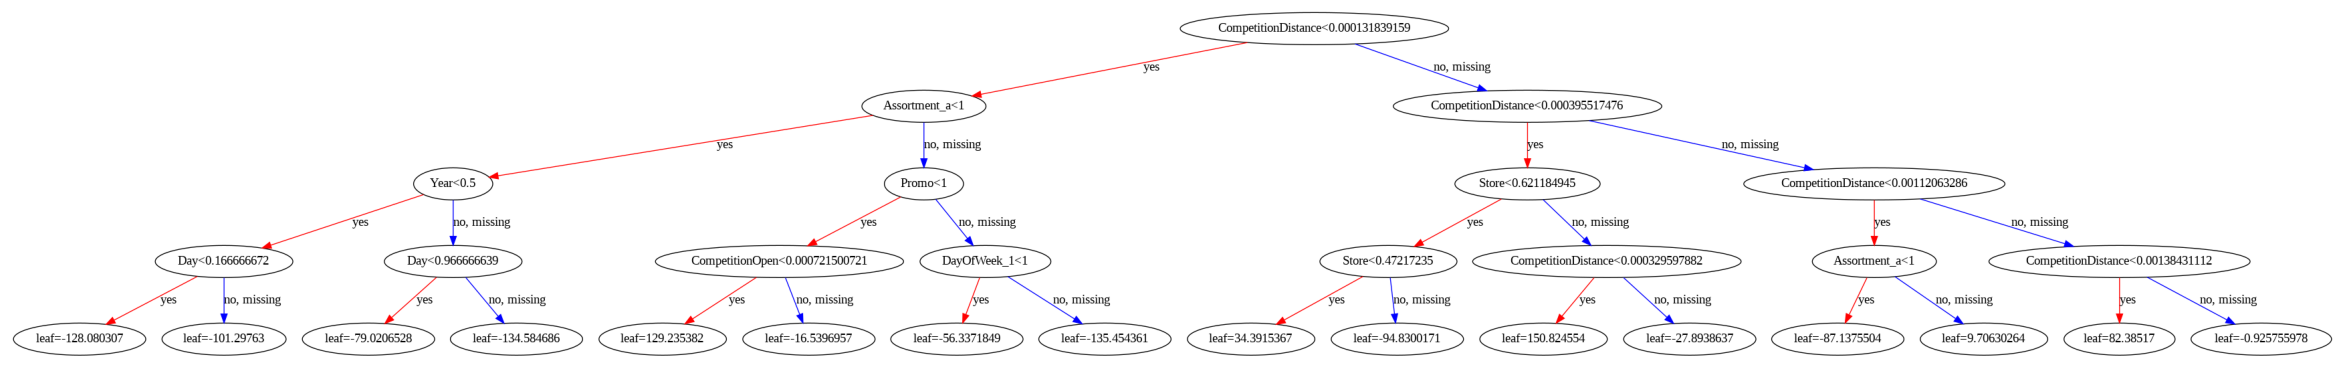

In [ ]:
plot_tree(model, rankdir='TB', num_trees=98)

In [ ]:
trees = model.get_booster().get_dump()

In [ ]:
len(trees)

100

In [ ]:
trees[0]

'0:[Promo<1] yes=1,no=2,missing=2\n\t1:[StoreType_b<1] yes=3,no=4,missing=4\n\t\t3:[Assortment_a<1] yes=7,no=8,missing=8\n\t\t\t7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16\n\t\t\t\t15:leaf=60.6733093\n\t\t\t\t16:leaf=-86.6292953\n\t\t\t8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18\n\t\t\t\t17:leaf=-155.676849\n\t\t\t\t18:leaf=-28.0212097\n\t\t4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10\n\t\t\t9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20\n\t\t\t\t19:leaf=218.256454\n\t\t\t\t20:leaf=1164.00403\n\t\t\t10:[DayOfWeek_7<1] yes=21,no=22,missing=22\n\t\t\t\t21:leaf=-62.4968376\n\t\t\t\t22:leaf=292.35379\n\t2:[DayOfWeek_1<1] yes=5,no=6,missing=6\n\t\t5:[Month<1] yes=11,no=12,missing=12\n\t\t\t11:[StoreType_b<1] yes=23,no=24,missing=24\n\t\t\t\t23:leaf=69.6078873\n\t\t\t\t24:leaf=403.191376\n\t\t\t12:[Day<0.200000003] yes=25,no=26,missing=26\n\t\t\t\t25:leaf=222.733994\n\t\t\t\t26:leaf=386.668945\n\t\t6:[Month<1] yes=13,no=14,missing=14\n\t

In [ ]:
importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

In [ ]:
importance_df.head(5)

,Feature,Importance
1,Promo,0.260257
12,DayOfWeek_1,0.100311
24,StoreType_b,0.075570
26,StoreType_d,0.057086
27,Assortment_a,0.052026


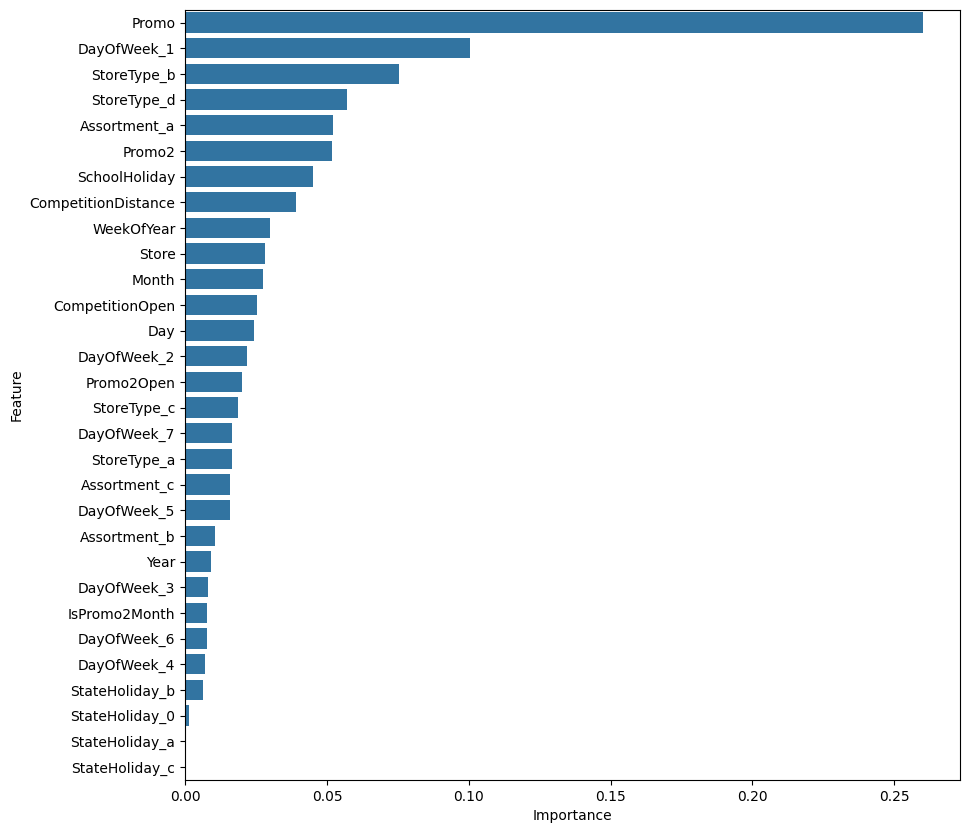

In [ ]:
# prompt: figure(fig.size=(10,10)
# sns.bartplot(data=importance_df, x='Importance')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.show()


**K-Fold Cross Validation**

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(n_splits=5)

In [ ]:
def train_and_evaluate(x_train, train_targets, x_val, val_targets, **params):
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(x_train, train_targets)
    train_rmse = rmse(model.predict(x_train), train_targets)
    val_rmse = rmse(model.predict(x_val), val_targets)
    return model, train_rmse, val_rmse

In [ ]:
models = []

for train_id, val_id in kfold.split(x):
    x_train, train_targets = x.iloc[train_id], targets.iloc[train_id]
    x_val, val_targets = x.iloc[val_id], targets.iloc[val_id]
    model, train_rmse, val_rmse = train_and_evaluate(x_train, train_targets, x_val, val_targets, n_estimators=100, learning_rate=0.1, max_depth=4)
    models.append(model)
    print(f'Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')

Train RMSE: 2263.9699, Validation RMSE: 2338.7903
Train RMSE: 2268.1677, Validation RMSE: 2305.4668
Train RMSE: 2263.8390, Validation RMSE: 2246.2310
Train RMSE: 2247.3546, Validation RMSE: 2360.5253
Train RMSE: 2257.9749, Validation RMSE: 2357.2402


In [ ]:
def predict_avg(models, inputs):
  return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, x)
preds

array([8054.4883, 7771.3604, 8862.119 , ..., 7858.575 , 7434.431 ,
       9422.162 ], dtype=float32)

In [ ]:
print(rmse(models[2].predict(x), targets))

2260.3285159462994


**Experiments**

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
x_train, x_val, train_target, val_target = train_test_split(x, targets, test_size=0.2)

In [ ]:
# prompt: create a rmspe function

import numpy as np
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


In [ ]:
model = xgb.XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.8, n_estimators=500, max_depth=15)
model.fit(x_train, train_target)
train_prediction = model.predict(x_train)
val_prediction = model.predict(x_val)

train_rmse = rmse(train_target, train_prediction)
val_rmse = rmse(val_target, val_prediction)

train_rmspe = rmspe(train_target, train_prediction)
val_rmspe = rmspe(val_target, val_prediction)

test_preds = model.predict(x_test)

print('RMSPE: Train rmse: {}, Validation rmse: {}'.format(train_rmspe, val_rmspe))
print('RMSE: Train rmse: {}, Validation rmse: {}'.format(train_rmse, val_rmse))

RMSPE: Train rmse: 3.6681934791544e-05, Validation rmse: 0.16882095914635425
RMSE: Train rmse: 0.19150012497424737, Validation rmse: 1000.5975402228411


In [ ]:
def test_param(**params):
  model = xgb.XGBRegressor(random_state=42, n_jobs=-1, **params)
  model.fit(x_train, train_target)
  train_prediction = model.predict(x_train)
  val_prediction = model.predict(x_val)

  train_rmse = rmse(train_target, train_prediction)
  val_rmse = rmse(val_target, val_prediction)

  train_rmspe = rmspe(train_target, train_prediction)
  val_rmspe = rmspe(val_target, val_prediction)

  test_pred = model.predict(x_test)

  print('RMSPE: Train rmse: {}, Validation rmse: {}'.format(train_rmspe, val_rmspe))
  print('RMSE: Train rmse: {}, Validation rmse: {}'.format(train_rmse, val_rmse))
  return test_preds

In [ ]:
test_preds = test_param(learning_rate=0.8, n_estimators=500, max_depth=15)

Train rmse: 0.41324170649953323, Validation rmse: 974.917175969323


In [ ]:
merged_test_df.shape

(41088, 24)

In [ ]:
submission_df = pd.DataFrame({
    'Id': merged_test_df['Id'],
    'Sales': test_preds
})

In [ ]:
submission_df['Sales'] = submission_df['Sales'] * test_df['Open'].fillna(1.)

In [ ]:
submission_df[submission_df.Sales <0]

,Id,Sales
10739,10740,-79.766678


In [ ]:
from google.colab import files
submission_df.to_csv('submission2.csv', index=False)
files.download('submission2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [ ]:
submission_df[submission_df['Sales']<0].count()

,0
Id,2
Sales,2


In [ ]:
submission_df

,Id,Sales
0,1,4352.979492
1,2,8058.479980
2,3,9221.106445
3,4,7882.455566
4,5,7283.072754
...,...,...
41083,41084,3222.873779
41084,41085,5463.527832
41085,41086,5430.605469
41086,41087,20071.091797
